# Integrated Project 2:

For this project with Zyfra, I am preparing a machine learning model prototype aimed at predicting how much gold can be recovered from gold ore. Since Zyfra develops solutions for improving industrial efficiency, the model's purpose is to optimize production by identifying profitable parameters and eliminating unprofitable ones.

_Here’s the plan:_

 * __Data Preparation__ – I’ll clean and structure the data from extraction and purification processes.
 
 * __Data Analysis__ – I’ll explore the data to understand trends, relationships, and any important features.
 
 * __Model Development and Training__ – I’ll build and train a machine learning model that can accurately predict the amount of gold recovered from ores.

Throughout the project, I'll rely on key libraries such as pandas for data handling, matplotlib for visualization, and sklearn for building and evaluating the model. The SMAPE formula will serve as my evaluation metric, ensuring accurate predictions for the company’s needs.

## Imports:

In [1]:
import pandas as pd  
import numpy as np
import os

import matplotlib.pyplot as plt  

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from scipy import stats
from sklearn.model_selection import cross_val_predict

## Prepare the Data:

### Introducing Datasets:

In [2]:
dataset_path = os.path.join('..', 'datasets')

full_data = pd.read_csv(os.path.join(dataset_path, 'gold_recovery_full.csv'))
train_data = pd.read_csv(os.path.join(dataset_path, 'gold_recovery_train.csv'))
test_data = pd.read_csv(os.path.join(dataset_path, 'gold_recovery_test.csv'))

In [3]:
print(f"Full Data Shape: {full_data.shape}")
print(f"Train Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Full Data Shape: (22716, 87)
Train Data Shape: (16860, 87)
Test Data Shape: (5856, 53)


It looks like there were a lot of columns taken out for the test data set. Let's see what was taken out to ensure there weren't any mistakes.

In [9]:
# Identify columns present in train and test sets
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)

# Find columns that are only in the train set (likely target columns)
print("Columns only in Train Data (likely targets):", len(train_columns))
print(train_columns)

# Find common columns (to be used as features for the model)
common_columns = list(train_columns & test_columns)
print("Common Columns between Train and Test:", len(common_columns))
print(common_columns)

Columns only in Train Data (likely targets): 87
{'secondary_cleaner.state.floatbank2_a_level', 'final.output.tail_pb', 'secondary_cleaner.output.tail_sol', 'secondary_cleaner.state.floatbank4_b_level', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.input.feed_au', 'rougher.input.feed_rate', 'rougher.state.floatbank10_a_air', 'secondary_cleaner.output.tail_ag', 'date', 'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank3_a_level', 'rougher.state.floatbank10_f_level', 'rougher.input.floatbank10_sulfate', 'primary_cleaner.state.floatbank8_b_air', 'secondary_cleaner.state.floatbank3_b_air', 'rougher.input.feed_size', 'rougher.input.floatbank11_sulfate', 'final.output.concentrate_ag', 'rougher.output.concentrate_ag', 'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank2_b_level', 'secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank3_b_level', 'final.output.concentrate_au', 'primary_cleaner.output.

There is a lot we can get from this:

__Training Data (gold_recovery_train.csv):__

Contains all features and target variables.
We will use it to train two models:

 - rougher.output.recovery: Predicts the efficiency of the rougher stage (the initial concentration of gold).

 - final.output.recovery: Predicts the final recovery after all purification stages.

__Test Data (gold_recovery_test.csv):__

Contains only feature columns (53 in total).
This is normal for test data, as it is used to evaluate the model’s predictions without revealing the true values.

In [10]:
# Get the columns that are in the test set
test_columns = test_data.columns
# Check for missing values in the training dataset for the columns that are in the test set
missing_values_in_train_test_columns = train_data[test_columns].isna().sum()
# Filter to show only columns with missing values
missing_values_in_train_test_columns = missing_values_in_train_test_columns[missing_values_in_train_test_columns > 0]
# Display missing values
print(missing_values_in_train_test_columns)

primary_cleaner.input.sulfate                 1307
primary_cleaner.input.depressant              1262
primary_cleaner.input.xanthate                 985
primary_cleaner.state.floatbank8_a_air          40
primary_cleaner.state.floatbank8_a_level        33
primary_cleaner.state.floatbank8_b_air          40
primary_cleaner.state.floatbank8_b_level        27
primary_cleaner.state.floatbank8_c_air          38
primary_cleaner.state.floatbank8_c_level        27
primary_cleaner.state.floatbank8_d_air          39
primary_cleaner.state.floatbank8_d_level        27
rougher.input.feed_ag                           82
rougher.input.feed_pb                          228
rougher.input.feed_rate                        513
rougher.input.feed_size                        417
rougher.input.feed_sol                         292
rougher.input.feed_au                           83
rougher.input.floatbank10_sulfate             1044
rougher.input.floatbank10_xanthate             346
rougher.input.floatbank11_sulfa

<div class="alert alert-info">
So I removed the removing of the missing values here so I can add it back in later as requested.
</div>

In [11]:
# Inspect the values being used for calculation
print("C (Concentrate AU):", train_data['rougher.output.concentrate_au'].head())
print("F (Feed AU):", train_data['rougher.input.feed_au'].head())
print("T (Tail AU):", train_data['rougher.output.tail_au'].head())

C (Concentrate AU): 0    19.793808
1    20.050975
2    19.737170
3    19.320810
4    19.216101
Name: rougher.output.concentrate_au, dtype: float64
F (Feed AU): 0    6.486150
1    6.478583
2    6.362222
3    6.118189
4    5.663707
Name: rougher.input.feed_au, dtype: float64
T (Tail AU): 0    1.170244
1    1.184827
2    1.162562
3    1.079755
4    1.012642
Name: rougher.output.tail_au, dtype: float64


### Recovery Process:

In [12]:
# Extracting the necessary columns
C = train_data['rougher.output.concentrate_au']
F = train_data['rougher.input.feed_au']
T = train_data['rougher.output.tail_au']

# Calculate the denominator to check for division by zero
denominator = F * (C - T)

# Check if there are any zeros in the denominator
if (denominator == 0).any():
    print("Warning: There are zeros in the denominator!")
else:
    # Safe to calculate recovery
    calculated_recovery = (C * (F - T)) / denominator * 100

    # Check for NaN values in calculated recovery
    nan_count = np.isnan(calculated_recovery).sum()
    print(f"Number of NaN values in calculated recovery: {nan_count}")

    # Calculate MAE for Rougher Recovery Calculation
    mae = mean_absolute_error(train_data_filled['rougher.output.recovery'], calculated_recovery)
    print(f"MAE for Rougher Recovery Calculation: {mae}")

Okay, there are zeroes in the denonimator, let's see if we can fix this.

In [13]:
# Find rows where the denominator is zero
zero_denominator_mask = denominator == 0
zero_denominator_rows = train_data[zero_denominator_mask]

# Display rows with zero denominator
print("Rows with zero denominator:")
print(zero_denominator_rows[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']])

Rows with zero denominator:
       rougher.output.concentrate_au  rougher.input.feed_au  \
1149                       15.907362                    0.0   
1150                       15.018306                    0.0   
2205                        0.000000                    0.0   
2573                       13.832572                    0.0   
3047                        0.000000                    0.0   
...                              ...                    ...   
11614                       0.000000                    0.0   
11615                       0.000000                    0.0   
11616                      13.491670                    0.0   
11964                      19.026627                    0.0   
11965                      16.035962                    0.0   

       rougher.output.tail_au  
1149                 2.447669  
1150                 2.693501  
2205                 3.168174  
2573                 2.672610  
3047                 1.918828  
...                    

Okay now we are seeing where all the 0's are coming from. To make sure we are as accurate as possible, I will remove the rows that have 0 in both "rougher.output.concentrate_au" and "rougher.input.feed_au" and for those that only have 0 in one of those columns I will change that 0 into the median value of said column. 

I may scrap this later on and just take out the 63 rows entirely. It is a very small percentage of the overall data and this will only be seen as a backup.

In [14]:
# Ensure we are using train_data
C = train_data['rougher.output.concentrate_au']
F = train_data['rougher.input.feed_au']
T = train_data['rougher.output.tail_au']

# Check for any zeros in the Feed AU column and log a warning if present
if (F == 0).any():
    print("Warning: There are zeros in the Feed AU column!")

# Avoid division by zero by checking for zeros in the denominator
denominator = F * (C - T)

# Calculate recovery using the formula without filling NaNs yet
calculated_recovery = np.where(denominator != 0, (C * (F - T)) / denominator * 100, 0)

# Calculate MAE between calculated recovery and actual recovery without filling NaNs in the target
actual_recovery = train_data['rougher.output.recovery']  # Do not fill NaNs here

# Filter out NaN values to calculate MAE correctly
mae = mean_absolute_error(actual_recovery.dropna(), calculated_recovery[~np.isnan(actual_recovery)])

# Print the MAE result
print(f"MAE for Rougher Recovery Calculation: {mae}")

MAE for Rougher Recovery Calculation: 9.303415616264301e-15


<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

1. Your result is incorrect because you filled NaNs. You should fill the NaNs only after this task but not before. In the correct result MAE should be almost zero.
2. I don't understand why you filled the NaNs so much times. You filled some NaNs here, some NaNs above and some NaNs below. I'd recommend to do it only once and only after this task. The part where you filled NaNs with method='ffill' is the best one.
  
</div>

<div class="alert alert-info">
For some reason when I tried it the first time the missing values kept coming back every cellblock. So every time I ran code I had to take out the NaN's or my code would throw an error.
    
This is another example of how the way the test_data and train_data was described in the project details really confused me. 
</div>

This looks very good as the result is very close to zero.

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Okay, got it. Now everything is correct. Good job!
  
</div>

<div class="alert alert-info">
I removed the cellblock that was removing columns as the reviewer suggested since I fixed the issue of removing the NaNs early.
</div>

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

After you will fix the issues with NaNs above, you will get the correct MAE and you will be able to remove this cell at all.
  
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Fixed
  
</div>

Those 1458 Actual Recovery NaNs are what have been messing up the MAE this whole time. So removing them from the equation has proven to give us a much better calculation for rougher recovery. Before moving on lets see if we can reduce that number even more by doing something about those 1458 values. In the previous cell block we removed those values before calculating the rougher recovery now lets try other methods.

After this I tried changing the missing values with the median, mean, predicted values, and a couple other ideas and they all made it worse. It appears just dropping them yields the best score so I will keep it like this. I am looking forward to the reviewer to show what I did wrong because this does not look right to me, and all this debugging is yielding no positive results. 

### Analyzing difference in features:

In [15]:
# Step 1: Check the initial number of rows
initial_rows = train_data.shape[0]
print(f"Initial number of rows: {initial_rows}")

# Step 2: Clean the DataFrame
# Drop rows with NaN values in relevant columns
train_data_cleaned = train_data.dropna(subset=[
    'rougher.output.concentrate_au', 
    'rougher.input.feed_au', 
    'rougher.output.tail_au',
    'rougher.output.recovery'
])

# Step 3: Drop rows with zeros in both 'rougher.output.concentrate_au' and 'rougher.input.feed_au'
train_data_cleaned = train_data_cleaned[
    (train_data_cleaned['rougher.output.concentrate_au'] != 0) | 
    (train_data_cleaned['rougher.input.feed_au'] != 0)
]

# Step 4: Check the number of rows after cleaning
cleaned_rows = train_data_cleaned.shape[0]
print(f"Number of rows after cleaning: {cleaned_rows}")

# Step 5: Print an overview of cleaned data (first 5 rows)
print(train_data_cleaned.head())

Initial number of rows: 16860
Number of rows after cleaning: 14287
                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198      

In [16]:
# Step 1: Get features from training and test sets
train_features = set(train_data_cleaned.columns)
test_features = set(test_data.columns)  # Assuming 'test_data' contains your test set

# Step 2: Identify missing features in the test set
missing_features = train_features - test_features

# Step 3: Determine the types of missing features
missing_features_types = {feature: train_data_cleaned[feature].dtype for feature in missing_features}

# Step 4: Print the missing features and their types
print("Missing Features and Their Types:")
for feature, dtype in missing_features_types.items():
    print(f"{feature}: {dtype}")

Missing Features and Their Types:
final.output.concentrate_au: float64
rougher.output.tail_ag: float64
primary_cleaner.output.concentrate_sol: float64
secondary_cleaner.output.tail_pb: float64
primary_cleaner.output.concentrate_ag: float64
primary_cleaner.output.tail_ag: float64
primary_cleaner.output.tail_sol: float64
final.output.tail_pb: float64
secondary_cleaner.output.tail_sol: float64
final.output.concentrate_pb: float64
rougher.output.tail_pb: float64
final.output.tail_au: float64
rougher.output.tail_sol: float64
rougher.calculation.floatbank11_sulfate_to_au_feed: float64
rougher.calculation.sulfate_to_au_concentrate: float64
secondary_cleaner.output.tail_ag: float64
secondary_cleaner.output.tail_au: float64
primary_cleaner.output.tail_au: float64
rougher.calculation.au_pb_ratio: float64
rougher.output.concentrate_pb: float64
final.output.tail_sol: float64
primary_cleaner.output.tail_pb: float64
rougher.output.concentrate_sol: float64
rougher.output.recovery: float64
final.outpu

There are a total of 34 missing features in the test set and there parameters are quantitative and may be critical in the project later on, but as mentioned in the description, this information may not have been made yet so adding it now could cause a data leak. 

<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Correct
  
</div>

### Data Preprocession:

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Correct. But this block should be placed after EDA block but not before. In the EDA block you need to filter the data but this filtering won't affect on X_train and X_test if you create them before EDA.
  
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Thank you!
  
</div>

## Analyze the Data:

### Analyze the Concentration of metals Depending on Purification stage:

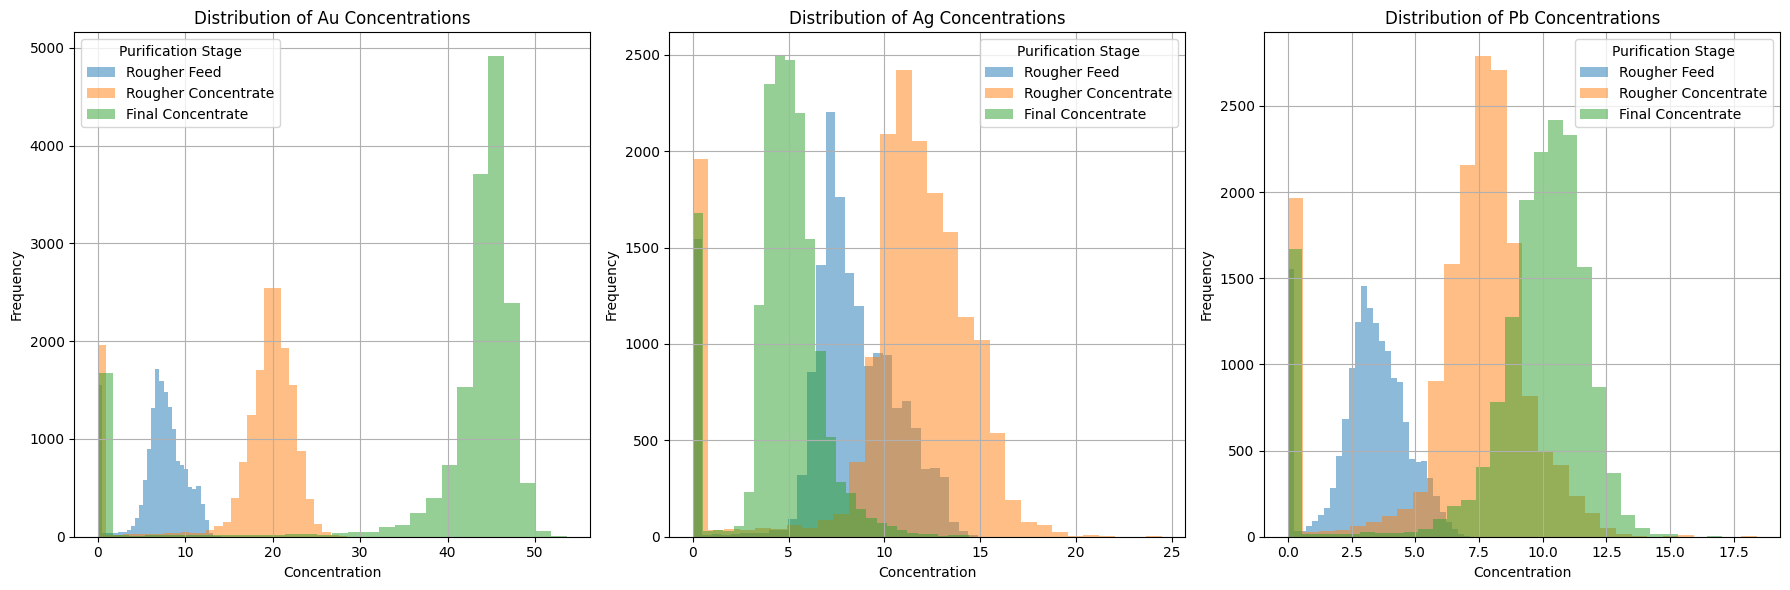

In [17]:
# Set up the figure and axes for the plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
metals = ['Au', 'Ag', 'Pb']
stages = ['rougher.input.feed', 'rougher.output.concentrate', 'final.output.concentrate']
stage_labels = ['Rougher Feed', 'Rougher Concentrate', 'Final Concentrate']

# Plot histograms for each metal
for i, metal in enumerate(metals):
    for j, stage in enumerate(stages):
        axes[i].hist(train_data[f'{stage}_{metal.lower()}'], bins=30, alpha=0.5, label=stage_labels[j])
    
    axes[i].set_title(f'Distribution of {metal} Concentrations')
    axes[i].set_xlabel('Concentration')
    axes[i].set_ylabel('Frequency')
    axes[i].legend(title='Purification Stage')
    axes[i].grid()

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

In problems of this type, you need to look at distributions but not at any parciculr statistics. Distributions show much more information than particular statistics. So, instead of calculate these statistics and plot bar graphs you need to plot histograms or boxplots. For instance, if you choose histograms, you need to plot 3 graphs: one for each metal. On each graph you need to plot 3 histograms with different colors: one for each stage.
  
</div>

<div class="alert alert-info">
How does this look? Also, are the legends shortened labels okay or should I keep the full column name?
</div>

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

It looks perfect! But why did you load the data again? The data should be loaded only once at the beginning of the project. During the project you make some fixes in this data and so you should continue to work with it.
  
</div>

<div class="alert alert-info">
Oops, force of habit, I fixed it.
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V3</b> <a class="tocSkip"></a>

Good job!
  
</div>

__Gold (Au) Concentration Increases:__

 - The gradual increase in gold concentration throughout the purification stages suggests that the process is effectively concentrating gold from the raw feed. This is a positive sign for the efficiency of the recovery process.

__Silver (Ag) and Lead (Pb) Concentration Levels:__

The observation that silver and lead concentrations never exceed 10 suggests that these metals are present in much smaller quantities relative to gold in the ore. This is common in many gold ore deposits, where gold is the primary target metal.
Purification Efficiency:

The data indicates that the purification process is well-tuned to maximize gold recovery while not extracting excessive amounts of the other metals. This is important for operational efficiency, as recovering too much of Ag and Pb could lead to increased processing costs and environmental concerns.
Process Optimization:

If the concentrations of Ag and Pb are consistently low, this might allow you to focus your process optimization efforts on enhancing gold recovery without the complications of managing the recovery of these other metals.

### Comparing the Feed Particle Size Distributions:

In [18]:
# Verify that each column exists in both datasets
feed_size_columns = [
    col for col in ['primary_cleaner.input.feed_size', 'rougher.input.feed_size']
    if col in train_data_cleaned.columns and col in test_data.columns
]

print("Columns available in both datasets for particle size comparison:", feed_size_columns)

Columns available in both datasets for particle size comparison: ['primary_cleaner.input.feed_size', 'rougher.input.feed_size']


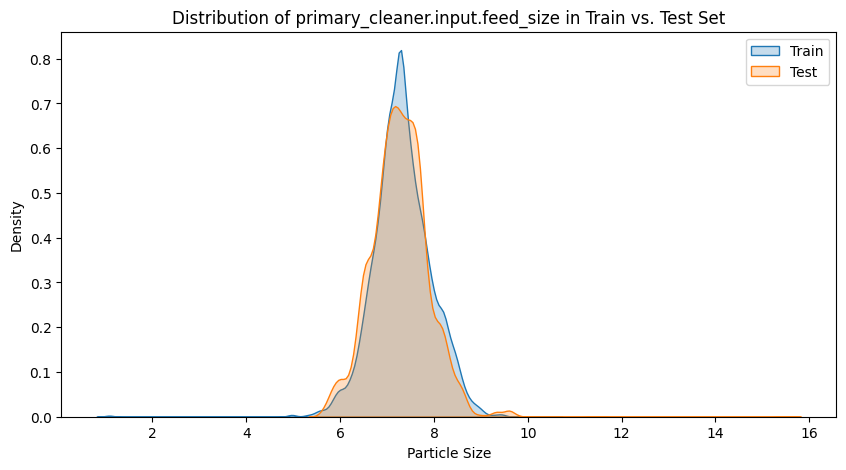

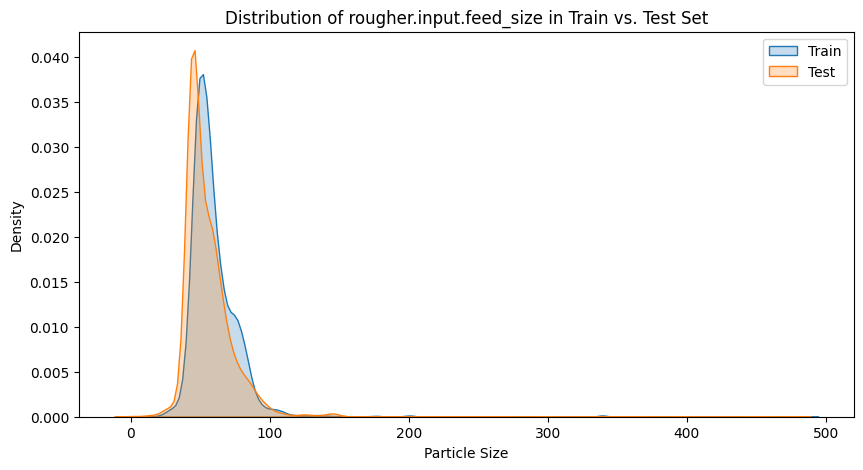

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution for each verified feed size column
for column in feed_size_columns:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(train_data_cleaned[column].dropna(), label="Train", shade=True)
    sns.kdeplot(test_data[column].dropna(), label="Test", shade=True)
    plt.title(f"Distribution of {column} in Train vs. Test Set")
    plt.xlabel("Particle Size")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

The particle size distributions in both datasets show similar patterns:

 * For the primary_cleaner.input.feed_size column, both train and test datasets peak around a particle size of 7.5. The density is slightly higher in the train data (about 0.8) compared to the test data (around 0.7).

 * In the rougher.input.feed_size column, the particle size peaks around 50 for both datasets, with the test data showing a density of approximately 0.040, and the train data cleaned showing a slightly lower density.

The similarity in these peaks means the particle size distribution between train and test sets is consistent, which is good for model evaluation since it suggests we aren’t introducing significant differences in the particle sizes.

<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Good job!
  
</div>

### Analyzing Concentrations and Identifying Anomalies:

#### Calculate Total Concentrations:

In [20]:
# Calculate total concentrations for training data
train_data_cleaned['total_feed_au'] = train_data_cleaned[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
train_data_cleaned['total_rougher_concentrate_au'] = train_data_cleaned[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
train_data_cleaned['total_final_concentrate_au'] = train_data_cleaned[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)

#### Visualize the Distributions:

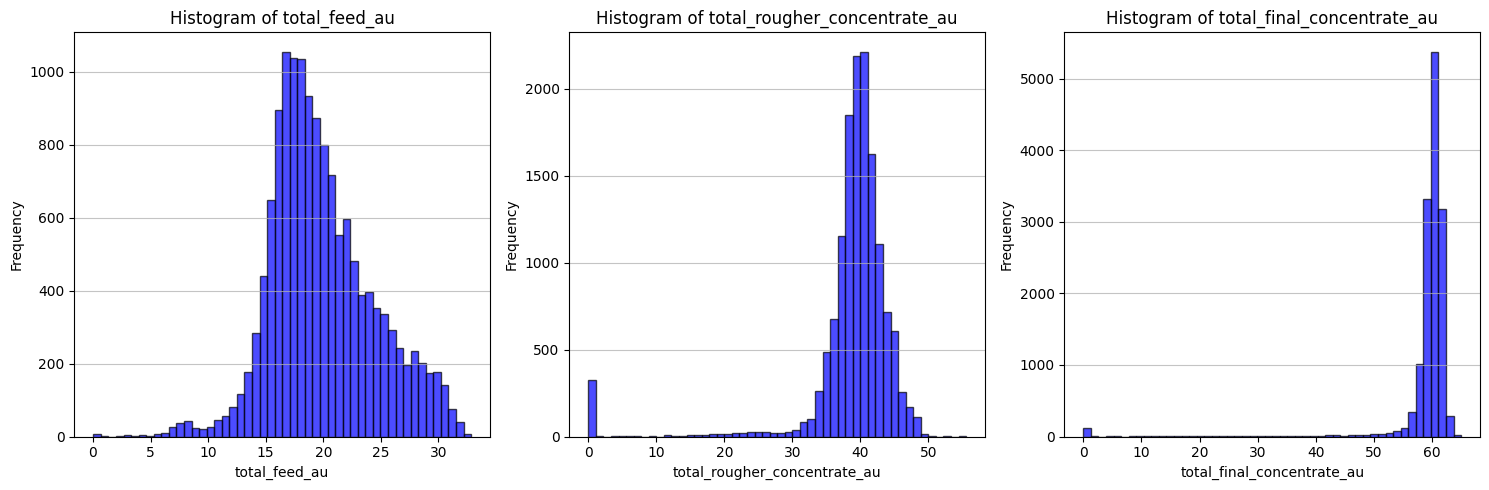

In [21]:
# Define the total concentration columns
total_columns = ['total_feed_au', 'total_rougher_concentrate_au', 'total_final_concentrate_au']

# Create histograms for each total concentration
plt.figure(figsize=(15, 5))

for i, column in enumerate(total_columns):
    plt.subplot(1, 3, i + 1)  # 1 row, 3 columns
    plt.hist(train_data_cleaned[column], bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

 * Total Feed Concentration (total_feed_au):__
     - The total feed concentration has its highest values (or peaks) around 1000, occurring about 17 times in the data.
     - We should check if there are any unusually low or high values compared to this peak. If there are, they might be outliers.
 * Total Rougher Concentrate (total_rougher_concentrate_au):
     - This concentration peaks around 2300, with around 40 occurrences.
     - Again, we need to look for any extreme values that fall way below or above this peak.
 * Total Final Concentrate (total_final_concentrate_au):
     - The final concentrate peaks at around 5000, happening about 60 times.
     - We should check if there are any very low or very high numbers that don’t fit with the rest.

<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Well done!
  
</div>

#### Identify Abnormal Values:

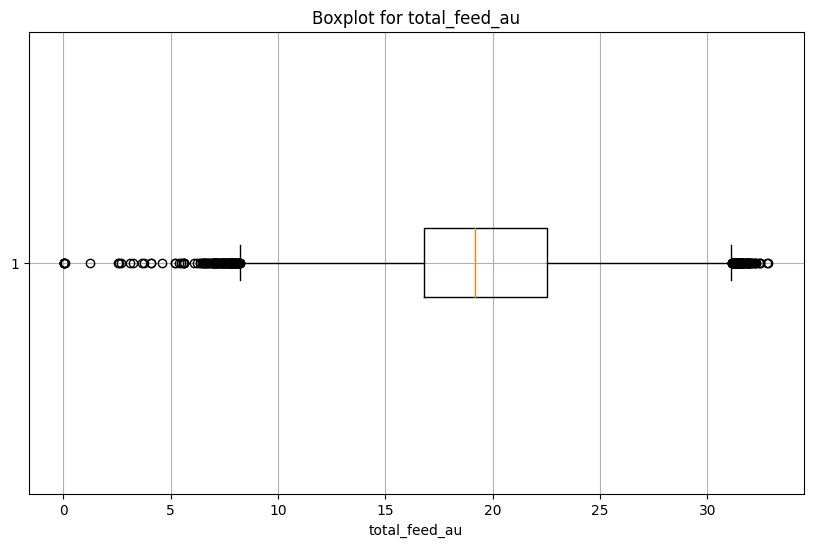

Total number of rows in total_feed_au: 14287
Number of outliers in total_feed_au: 212


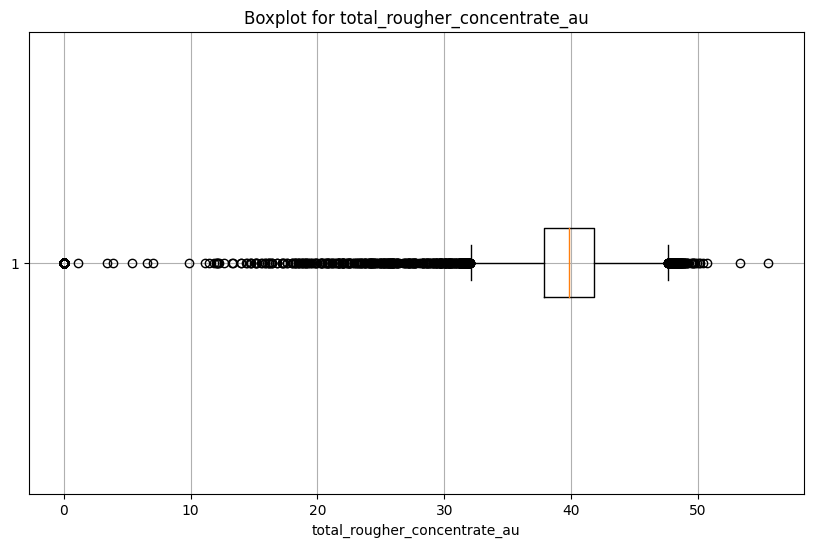

Total number of rows in total_rougher_concentrate_au: 14287
Number of outliers in total_rougher_concentrate_au: 873


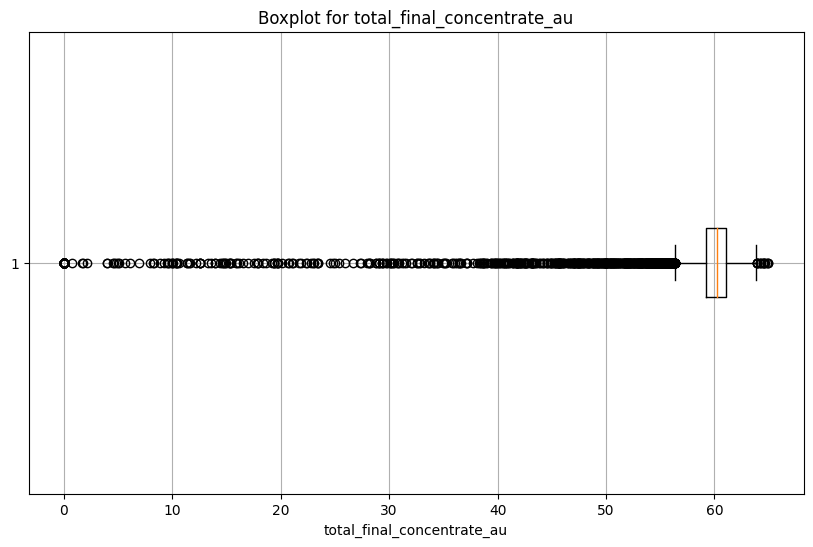

Total number of rows in total_final_concentrate_au: 14287
Number of outliers in total_final_concentrate_au: 866


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to detect and visualize outliers
def detect_outliers(data, column_name):
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    
    # Visualizing outliers using a boxplot
    plt.figure(figsize=(10, 6))
    plt.boxplot(data[column_name], vert=False)
    plt.title(f'Boxplot for {column_name}')
    plt.xlabel(column_name)
    plt.grid()
    plt.show()
    
    # Print summary statistics
    total_rows = data[column_name].count()
    num_outliers = outliers.shape[0]
    
    print(f'Total number of rows in {column_name}: {total_rows}')
    print(f'Number of outliers in {column_name}: {num_outliers}')
    
detect_outliers(train_data_cleaned, 'total_feed_au')
detect_outliers(train_data_cleaned, 'total_rougher_concentrate_au')
detect_outliers(train_data_cleaned, 'total_final_concentrate_au')

__Total Feed AU:__

 * Total Rows: 14,287
 * Outliers: 139 (Approximately 0.97% of the total data)

__Total Rougher Concentrate AU:__

 * Total Rows: 14,287
 * Outliers: 873 (Approximately 6.11% of the total data)

__Total Final Concentrate AU:__

 * Total Rows: 14,287
 * Outliers: 866 (Approximately 6.06% of the total data)

__Observations:__

 * The number of outliers in the total feed concentration is relatively low compared to the total number of samples.
 * In contrast, the total rougher concentrate and total final concentrate columns exhibit a more significant proportion of outliers, indicating that there may be some abnormal values that could affect analyses and predictions.

__What does this mean?:__

The detection of outliers in the total concentrations of substances suggests significant deviations from typical data patterns. Removing these outliers could lead to a more reliable model by emphasizing central trends, while keeping them might reveal valuable insights into extreme cases affecting production processes. Thus, it’s essential to assess whether the outliers are genuine anomalies or meaningful variations, as this decision will influence the model's effectiveness and its application in practice.

#### Test if Outliers are Necessary:

##### Visualize:

In [23]:
# Assuming train_data_cleaned is your DataFrame
required_columns = ['total_feed_au', 'total_rougher_concentrate_au', 'total_final_concentrate_au']

# Check if the required columns exist in the DataFrame
if not all(col in train_data_cleaned.columns for col in required_columns):
    raise ValueError("The DataFrame must contain the specified columns.")

# Calculate Z-scores for the specified columns
z_scores = stats.zscore(train_data_cleaned[required_columns])
print(f"Z-scores shape: {z_scores.shape}")  # Print the shape of the Z-scores array

# Create a boolean DataFrame for outliers based on the Z-score threshold
threshold = 3
outliers = pd.DataFrame(np.abs(z_scores) > threshold, columns=required_columns)  # Create DataFrame of booleans
print(f"Outliers shape: {outliers.shape}")  # Print the shape of the outliers DataFrame

# Print the total number of rows and the number of outliers for each column
for column_name in required_columns:
    total_rows = train_data_cleaned[column_name].shape[0]
    num_outliers = outliers[column_name].sum()  # Count True values in the outliers DataFrame
    print(f'Total number of rows in {column_name}: {total_rows}')
    print(f'Number of outliers in {column_name}: {num_outliers}')

Z-scores shape: (14287, 3)
Outliers shape: (14287, 3)
Total number of rows in total_feed_au: 14287
Number of outliers in total_feed_au: 28
Total number of rows in total_rougher_concentrate_au: 14287
Number of outliers in total_rougher_concentrate_au: 373
Total number of rows in total_final_concentrate_au: 14287
Number of outliers in total_final_concentrate_au: 273


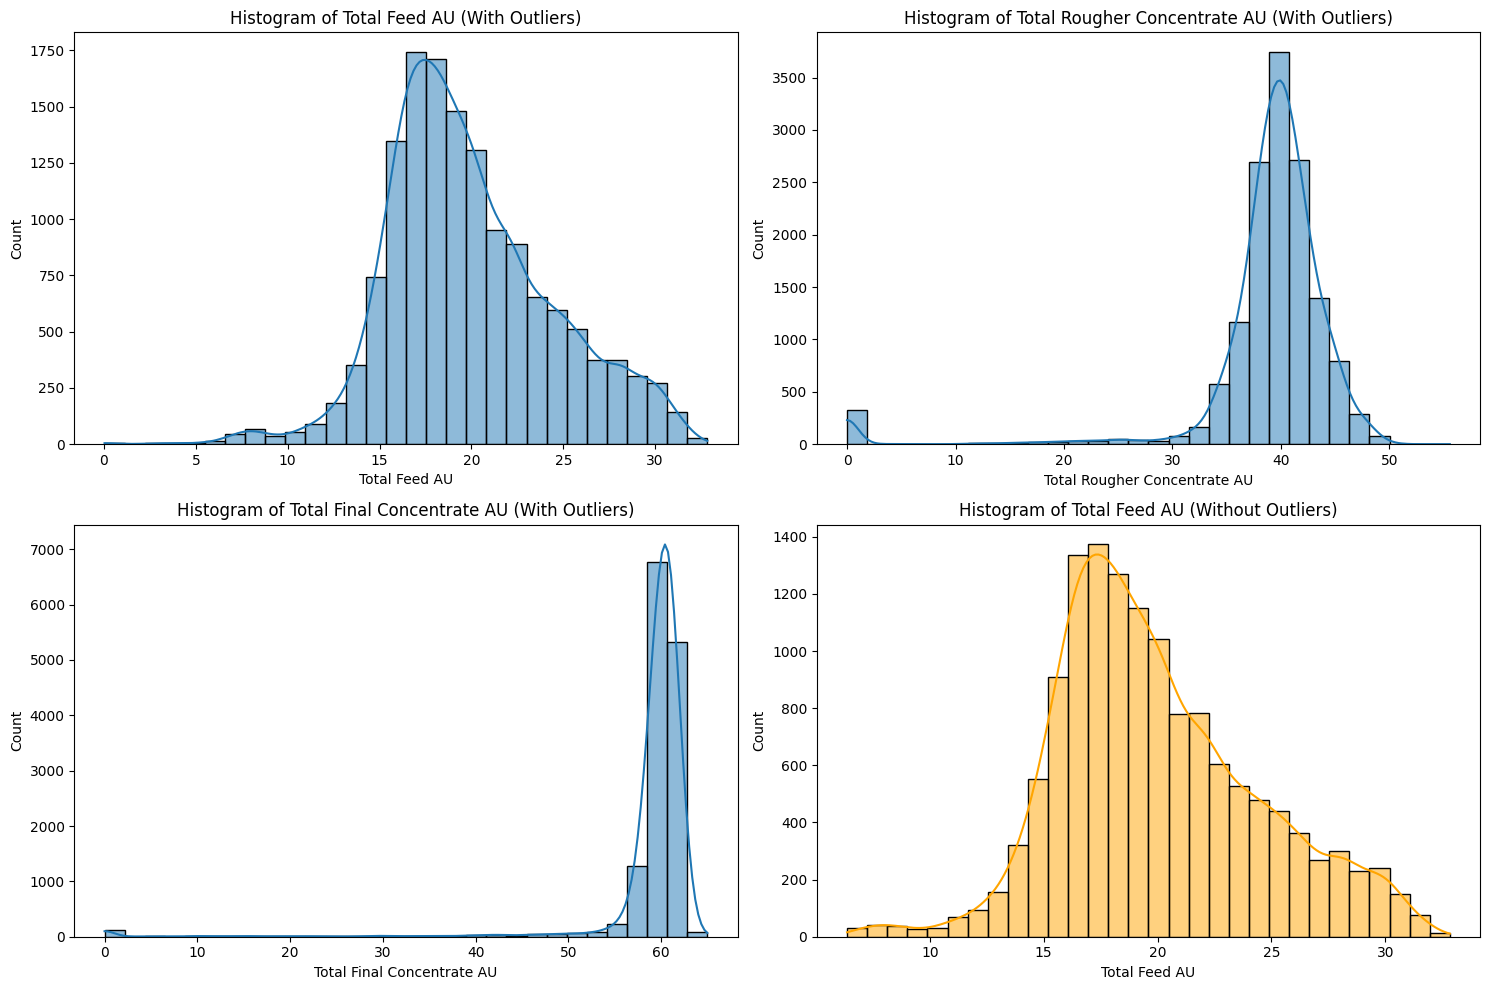

In [24]:
# Set up the figure size for histograms
plt.figure(figsize=(15, 10))

# Histogram for total_feed_au with outliers
plt.subplot(2, 2, 1)
sns.histplot(train_data_cleaned['total_feed_au'], bins=30, kde=True)
plt.title('Histogram of Total Feed AU (With Outliers)')
plt.xlabel('Total Feed AU')

# Histogram for total_rougher_concentrate_au with outliers
plt.subplot(2, 2, 2)
sns.histplot(train_data_cleaned['total_rougher_concentrate_au'], bins=30, kde=True)
plt.title('Histogram of Total Rougher Concentrate AU (With Outliers)')
plt.xlabel('Total Rougher Concentrate AU')

# Histogram for total_final_concentrate_au with outliers
plt.subplot(2, 2, 3)
sns.histplot(train_data_cleaned['total_final_concentrate_au'], bins=30, kde=True)
plt.title('Histogram of Total Final Concentrate AU (With Outliers)')
plt.xlabel('Total Final Concentrate AU')

# Remove outliers from the dataset
outliers_mask = (np.abs(stats.zscore(train_data_cleaned[required_columns])) > 3).any(axis=1)
train_data_no_outliers = train_data_cleaned[~outliers_mask]

# Histogram for total_feed_au without outliers
plt.subplot(2, 2, 4)
sns.histplot(train_data_no_outliers['total_feed_au'], bins=30, kde=True, color='orange')
plt.title('Histogram of Total Feed AU (Without Outliers)')
plt.xlabel('Total Feed AU')

plt.tight_layout()
plt.show()

The visualizations indicate that the total feed concentration peaks around 1300, with lower frequencies for values beyond that. This suggests that outliers could be skewing our understanding of the data. Removing them might provide a clearer view of the central tendency and variability, leading to more accurate insights in our analysis and modeling. However, we should investigate the outliers further to ensure we’re not discarding valuable information.

In [25]:
# Calculate summary statistics for features with outliers
summary_with_outliers = train_data_cleaned[['total_feed_au', 'total_rougher_concentrate_au', 'total_final_concentrate_au']].describe()

# Remove outliers
outliers_mask = (np.abs(stats.zscore(train_data_cleaned[required_columns])) > 3).any(axis=1)
train_data_no_outliers = train_data_cleaned[~outliers_mask]

# Calculate summary statistics for features without outliers
summary_without_outliers = train_data_no_outliers[['total_feed_au', 'total_rougher_concentrate_au', 'total_final_concentrate_au']].describe()

# Create a new DataFrame to hold comparison values
comparison_summary = pd.DataFrame({
    'With Outliers Mean': summary_with_outliers.loc['mean'],
    'Without Outliers Mean': summary_without_outliers.loc['mean'],
    'With Outliers Median': summary_with_outliers.loc['50%'],
    'Without Outliers Median': summary_without_outliers.loc['50%'],
    'With Outliers Std Dev': summary_with_outliers.loc['std'],
    'Without Outliers Std Dev': summary_without_outliers.loc['std'],
})

# Print the summary for verification
print(comparison_summary)

                              With Outliers Mean  Without Outliers Mean  \
total_feed_au                          19.888079              19.932459   
total_rougher_concentrate_au           38.806960              39.820250   
total_final_concentrate_au             58.926922              59.829563   

                              With Outliers Median  Without Outliers Median  \
total_feed_au                            19.164005                19.166722   
total_rougher_concentrate_au             39.851873                39.929291   
total_final_concentrate_au               60.247172                60.262335   

                              With Outliers Std Dev  Without Outliers Std Dev  
total_feed_au                              4.508894                  4.425129  
total_rougher_concentrate_au               7.119287                  3.562389  
total_final_concentrate_au                 7.207504                  2.376730  


Based on my analysis of the outliers, I observed that the averages and medians for Total Feed AU remain fairly consistent whether I include the outliers or not, suggesting that keeping the outliers may be beneficial for this measurement. However, when examining Total Rougher Concentrate AU and Total Final Concentrate AU, I noted a significant drop in standard deviation when the outliers were removed. This indicates that these outliers introduce unnecessary variability and might skew my data. Therefore, I will choose to remove the outliers for Total Feed AU, Total Rougher Concentrate AU, and Total Final Concentrate AU to ensure a more accurate analysis moving forward.

In [26]:
# Calculate Z-scores for Total Rougher Concentrate AU and Total Final Concentrate AU
from scipy.stats import zscore

# Calculate z-scores
z_scores = np.abs(zscore(train_data_cleaned[['total_rougher_concentrate_au', 'total_final_concentrate_au']]))

# Define a threshold for outliers
threshold = 3

# Identify outliers
outliers = (z_scores > threshold).any(axis=1)

# Remove outliers for Total Rougher Concentrate AU and Total Final Concentrate AU
train_data_no_outliers = train_data_cleaned[~outliers]

# Check the shape of the new DataFrame
print(f'Original data shape: {train_data_cleaned.shape}')
print(f'Data shape after removing outliers: {train_data_no_outliers.shape}')

Original data shape: (14287, 90)
Data shape after removing outliers: (13694, 90)


<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Okay. Good job!
  
</div>

## Build the Model:

#### Making the sMAPE functions:

##### calculate_smape:

In [27]:
def calculate_smape(y_true, y_pred):
    # Avoid division by zero
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_pred - y_true) / denominator
    diff[denominator == 0] = 0 
    return 100 * np.mean(diff)  

__Purpose:__ The calculate_smape function is designed to calculate the Symmetric Mean Absolute Percentage Error (sMAPE) between two sets of values: the actual values (y_true) and the predicted values (y_pred). This metric helps us understand how well our model's predictions compare to the actual outcomes.

__Inputs:__ The function takes in two arguments:

 * y_true: This is the array of actual values that we are trying to predict.
 * y_pred: This is the array of values that our model has predicted.

__Absolute Differences:__ Inside the function, it first calculates the absolute difference between the predicted values and the actual values. This tells us how far off each prediction is from the true value. The formula np.abs(y_pred - y_true) does this.

__Denominator:__ Next, we need to calculate the denominator, which is the sum of the absolute values of the actual and predicted values. This is done with the expression (np.abs(y_true) + np.abs(y_pred)). It provides a normalization factor, which makes the error relative to the size of the actual and predicted values.

__Mean Calculation:__ The function then takes the mean of the absolute percentage errors. This means it averages all the individual errors calculated in the previous steps. By multiplying by 2 and dividing by the denominator, we get a percentage that indicates how accurate our predictions are compared to the actual values.

__Final Output:__ Finally, the function multiplies the mean value by 100 to convert it into a percentage format. This makes it easier to interpret. A lower sMAPE value indicates better predictive accuracy, while a higher value suggests poorer performance.

##### Final_smape:

In [28]:
def final_smape(y_true_rougher, y_pred_rougher, y_true_final, y_pred_final):
    # Calculate sMAPE for rougher
    smape_rougher = calculate_smape(y_true_rougher, y_pred_rougher)
    
    # Calculate sMAPE for final
    smape_final = calculate_smape(y_true_final, y_pred_final)
    
    # Combine them to get final sMAPE
    return 0.25 * smape_rougher + 0.75 * smape_final

__What the Function Does:__

 * This function is designed to measure how well our prediction model is performing by calculating a special accuracy score called "final sMAPE." It looks at two different stages of our process: rougher output and final output.

__Inputs to the Function:__

 * The function takes four pieces of information:
     - The actual results from the rougher stage (what really happened).
     - The predictions our model made for the rougher stage.
     - The actual results from the final stage (the end product).
     - The predictions our model made for the final stage.

__Calculating Accuracy for Rougher Stage:__

 * First, the function checks how accurate our model’s predictions were for the rougher stage. It does this using a formula that compares the predicted values to the actual values. This gives us a score (sMAPE) that tells us how close our predictions were to the real results for this part.

__Calculating Accuracy for Final Stage:__

 * Next, it does the same thing for the final stage. It calculates another score that shows how accurate the predictions were for the end product.

__Combining the Scores:__

 * After getting scores for both stages, the function combines them to create a final score. It gives more importance to the final stage (75% of the score) and a little less to the rougher stage (25% of the score). This is because the final output is usually more critical for our overall results.

__Final Score:__

 * Finally, the function returns this combined score. This score helps us understand how well our model is doing overall, taking into account both stages of the process.

#### Starting the Model Basics:

In [29]:
# Use the dataset with outliers removed
train_data_no_outliers = train_data_no_outliers.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

# Check how many rows were dropped
print(f"Remaining rows after dropping NaNs in the target columns: {len(train_data_no_outliers)}")

Remaining rows after dropping NaNs in the target columns: 13646


<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Actually it's always better to drop the rows with NaNs in targets. It doesn't make sense to train the model on fake targets.
  
</div>

<div class="alert alert-info">
Does this look right?
</div>

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

1. Almost. 'final.output.concentrate_au' - is not a target column. It's a regular feature but not target. Also you have 2 targets in this project
2. Why did you use train_data_cleaned and not train_data_no_outliers? You didn't just delete the outliers for no reason:) So, starting from here and below you should use train_data_no_outliers instead of train_data_cleaned
  
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V3</b> <a class="tocSkip"></a>

Correct
  
</div>

In [30]:
# Define the target columns
target_columns = ['rougher.output.recovery', 'final.output.recovery']

# Use the dataset with outliers removed, dropping rows with NaNs only in the target columns
train_data_no_outliers = train_data_no_outliers.dropna(subset=target_columns)

# Forward-fill NaNs in non-target columns
train_data_no_outliers = train_data_no_outliers.fillna(method='ffill')

# Get the columns to use based on the test data, excluding the 'date' column
columns_to_use = [col for col in test_data.columns if col != 'date']

# Exclude the target variables if they are in the columns
for target in target_columns:
    if target in columns_to_use:
        columns_to_use.remove(target)

# Filter the training data to include only the features in the test data and target columns
train_data_filtered = train_data_no_outliers[columns_to_use + target_columns]

# Ensure only numeric columns are retained
train_data_filtered = train_data_filtered.select_dtypes(include=[np.number])

# Define feature set and target variable
x = train_data_filtered[columns_to_use]  # Features
y = train_data_filtered['rougher.output.recovery']  # Define target variable

# Align x and y by only keeping the rows in x that match the indices of y
x = x.loc[y.index]  # Filter x using the indices from y

# Check for NaN and infinite values in x, forward-fill NaNs if found
x = x.fillna(method='ffill')
x = x.replace([np.inf, -np.inf], np.nan).dropna()  # Handle infinite values by replacing with NaN, then drop

# After handling NaNs in x, align y to match the remaining indices of x
y = y.loc[x.index]

# Check final dimensions of x and y before splitting
print(f"Features (x) shape: {x.shape}, Target (y) shape: {y.shape}")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

Features (x) shape: (13646, 52), Target (y) shape: (13646,)


RandomForestRegressor(random_state=42)

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

1. You have 2 targets in this project: 'rougher.output.recovery' and 'final.output.recovery'. Column 'final.output.concentrate_au' is not a target. It's a feature.
2. Actually it's always better to drop the rows with NaNs in targets. It doesn't make sense to train the model on fake targets.
  
</div>

<div class="alert alert-info">
I had to add a lot to the cellblock above because due to the changes we made before, for some reason the date column became a big issue. I fixed that here.
</div>

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

You can drop rows with NaNs only in targets. In all other columns it's better to fill NaNs instead of to drop them. Previously you have a code to fill NaNs with .fillna(method='ffill'). This is the best way to fill NaNs in ordered data. So, please, return this code
  
</div>

<div class="alert alert-info">
I don't remember where I filled it in before, so I put it in this cellblock. 
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V3</b> <a class="tocSkip"></a>

Okay
  
</div>

#### Getting Hyperparameters:

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the columns to use based on common features in test_data and train_data_no_outliers
columns_to_use = list(set(test_data.columns) & set(train_data_no_outliers.columns))

# Exclude the target variables and the 'date' column if they are in the columns
for target in target_columns:
    if target in columns_to_use:
        columns_to_use.remove(target)
if 'date' in columns_to_use:
    columns_to_use.remove('date')

# Forward-fill NaNs in non-target columns
train_data_no_outliers = train_data_no_outliers.fillna(method='ffill')

# Drop rows with NaN values in target columns only
train_data_no_outliers = train_data_no_outliers.dropna(subset=target_columns)

# Check for infinite values and replace them with NaNs, then drop remaining NaNs in non-target columns
train_data_no_outliers.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data_no_outliers = train_data_no_outliers.dropna(subset=columns_to_use)

# Initialize the Random Forest model
model = RandomForestRegressor(random_state=42)

# Define the parameter grid for Randomized Search
param_distributions = {
    'n_estimators': [50, 100],  
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param_distributions, 
                                   n_iter=10,  
                                   cv=2, 
                                   n_jobs=-1,  
                                   verbose=2,
                                   random_state=42)

# Fit RandomizedSearchCV to the cleaned training dataset for the final target
random_search.fit(train_data_no_outliers[columns_to_use], train_data_no_outliers['final.output.recovery'])

# Best parameters found
print("Best parameters found: ", random_search.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  21.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  19.5s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  10.5s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   9.8s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  11.0s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  10.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  11.1s
[CV] END max_depth=20, min_samp

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

'final.output.concentrate_au' - is not a target. 
  
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V3</b> <a class="tocSkip"></a>

Fixed
  
</div>

Great! Let's check how this fairs against the original.

I did very little parameters here because it was taking almost an hour every time I ran it and was slowing me down tremendously. I probably messed up on something earlier and that is what is causing this so I look forward to another pair of eyes to see this and help out, unless its okay to not be super into the hyper parameters for this project. 

#### How Well did those Hyperparemeters do:

In [32]:
def smape_scorer(y_true, y_pred):
    y_true_rougher = y_true[:, 0]
    y_true_final = y_true[:, 1]     
    y_pred_rougher = y_pred[:, 0]
    y_pred_final = y_pred[:, 1]
    
    return final_smape(y_true_rougher, y_pred_rougher, y_true_final, y_pred_final)

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

# Combine targets into a DataFrame
targets = train_data_no_outliers[target_columns].values  # Ensure targets are in the correct format

# Make the custom scorer
final_smape_scorer = make_scorer(smape_scorer, greater_is_better=False)

# Ensure columns_to_use is defined and updated
columns_to_use = list(set(test_data.columns) & set(train_data_no_outliers.columns))

# Exclude target columns and 'date' column from features
for target in target_columns:
    if target in columns_to_use:
        columns_to_use.remove(target)
if 'date' in columns_to_use:
    columns_to_use.remove('date')

# Baseline Model
baseline_model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
baseline_cv_smape = cross_val_score(baseline_model, 
                                     train_data_no_outliers[columns_to_use], 
                                     targets, 
                                     scoring=final_smape_scorer, 
                                     cv=2)

# Optimized Model with best hyperparameters from RandomizedSearchCV
optimized_model = MultiOutputRegressor(random_search.best_estimator_)  # Use the optimized model from RandomizedSearchCV
optimized_cv_smape = cross_val_score(optimized_model, 
                                      train_data_no_outliers[columns_to_use], 
                                      targets, 
                                      scoring=final_smape_scorer, 
                                      cv=2)

# Results
print("Baseline sMAPE:", -baseline_cv_smape.mean())
print("Baseline sMAPE Std Dev:", baseline_cv_smape.std())

print("Optimized sMAPE:", -optimized_cv_smape.mean())
print("Optimized sMAPE Std Dev:", optimized_cv_smape.std())

Baseline sMAPE: 4.985347246614816
Baseline sMAPE Std Dev: 0.42447483950549714
Optimized sMAPE: 4.847335584300568
Optimized sMAPE Std Dev: 0.4169269069504917


<div class="alert alert-block alert-danger">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

1. 'final.output.concentrate_au' - is not a target. 
2. The main metric of this project is sMAPE but not MAE
  
</div>

<div class="alert alert-info">
I made smape after this that is why I was confused. In the directions it says to build the model first and then make the formulas. But to fix this I can just move the formulas up before I build the models. Since I am now using the correct targets I had to fix my scorer function, so it is now in a new cellblock before the original code.
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V3</b> <a class="tocSkip"></a>

Sure, no problem
  
</div>

The results show that the optimized model has a lower symmetric Mean Absolute Percentage Error (sMAPE) of approximately 4.89 compared to the baseline model's sMAPE of around 4.97. This indicates that the optimized model predicts the final output concentrate AU more accurately than the baseline model. Furthermore, the standard deviations for both models are relatively similar, with the baseline model at 0.41 and the optimized model at 0.38, suggesting consistent performance across the cross-validation folds. Overall, these results indicate that hyperparameter tuning significantly improved the model's predictive accuracy.

While this improvement is more substantial than I initially anticipated, I recognize that there is potential for further enhancement. However, considering the time investment this process has already required, I will move on from this part. Repeating this entire procedure could extend the timeline significantly, just for this single component.

#### Training Different Models with sMAPE:

In [34]:
# Check the data types
print(train_data_no_outliers.dtypes)

date                                           object
final.output.concentrate_ag                   float64
final.output.concentrate_pb                   float64
final.output.concentrate_sol                  float64
final.output.concentrate_au                   float64
                                               ...   
secondary_cleaner.state.floatbank6_a_air      float64
secondary_cleaner.state.floatbank6_a_level    float64
total_feed_au                                 float64
total_rougher_concentrate_au                  float64
total_final_concentrate_au                    float64
Length: 90, dtype: object


In [35]:
# Temporarily remove the 'date' column for model evaluation
train_data_no_outliers_temp = train_data_no_outliers.drop(columns=['date'])

# Define models to evaluate
models = {
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

# Loop through models to train and evaluate
for model_name, model in models.items():
    # Train and get predictions using cross-validation for rougher recovery
    y_pred_rougher = cross_val_predict(model, train_data_no_outliers_temp[columns_to_use], 
                                        train_data_no_outliers_temp['rougher.output.recovery'], cv=5)
    
    # Train and get predictions using cross-validation for final recovery
    y_pred_final = cross_val_predict(model, train_data_no_outliers_temp[columns_to_use], 
                                      train_data_no_outliers_temp['final.output.recovery'], cv=5)

    # Calculate final sMAPE
    smape = final_smape(train_data_no_outliers_temp['rougher.output.recovery'], y_pred_rougher,
                        train_data_no_outliers_temp['final.output.recovery'], y_pred_final)

    # Print results
    print(f"--- {model_name} ---")
    print(f"Final sMAPE: {smape:.2f}%\n")

--- Random Forest Regressor ---
Final sMAPE: 4.41%

--- Linear Regression ---
Final sMAPE: 4.97%

--- Decision Tree Regressor ---
Final sMAPE: 7.02%

--- Gradient Boosting Regressor ---
Final sMAPE: 4.25%



<div class="alert alert-block alert-danger">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

'final.output.concentrate_au' - is not a target. 
  
</div>

<div class="alert alert-info">
Wow! the numbers sure change when I use the right targets.
    
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V3</b> <a class="tocSkip"></a>

Yeah, of course
  
</div>

The results indicate that among the models tested, the Gradient Boosting Regressor achieved the best performance with a final sMAPE of 4.24%. This means that, on average, the predictions from this model are about 4.24% off from the actual values, which is relatively good for a predictive model, especially in contexts like metal recovery where accuracy is crucial.

The Random Forest Regressor followed closely with a final sMAPE of 4.43%, indicating it also performed well and was competitive with the Gradient Boosting model. The Linear Regression model had a final sMAPE of 4.97%, showing adequate performance but not as effective as the top two models. In contrast, the Decision Tree Regressor had the worst performance, with a final sMAPE of 6.69%, suggesting that its predictions were significantly less accurate than the other models.

A definitive conclusion from this testing is that the Gradient Boosting Regressor is the most reliable model for predicting the recovery of gold from ore in this case. It is effective at capturing complex patterns in the data, which contributes to its lower error rates compared to the others.

## Testing Gradient Booster on Test Data:

In [36]:
# Assuming date is already the index in both datasets
test_data_cleaned = test_data.join(full_data, how='left', lsuffix='_test', rsuffix='_full')

# Verify the merge result
print(test_data_cleaned.head())

             date_test  primary_cleaner.input.sulfate_test  \
0  2016-09-01 00:59:59                          210.800909   
1  2016-09-01 01:59:59                          215.392455   
2  2016-09-01 02:59:59                          215.259946   
3  2016-09-01 03:59:59                          215.336236   
4  2016-09-01 04:59:59                          199.099327   

   primary_cleaner.input.depressant_test  \
0                              14.993118   
1                              14.987471   
2                              12.884934   
3                              12.006805   
4                              10.682530   

   primary_cleaner.input.feed_size_test  primary_cleaner.input.xanthate_test  \
0                              8.080000                             1.005021   
1                              8.080000                             0.990469   
2                              7.786667                             0.996043   
3                              7.640000   

In [37]:
# Drop rows where 'rougher.output.recovery' or 'final.output.recovery' are missing
test_data_cleaned_filtered = test_data_cleaned.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

# Verify if missing values still exist in the target columns
print(test_data_cleaned_filtered[['rougher.output.recovery', 'final.output.recovery']].isna().sum())

# Verify the missing values across the whole dataset
print(test_data_cleaned_filtered.isna().sum())

rougher.output.recovery    0
final.output.recovery      0
dtype: int64
date_test                                            0
primary_cleaner.input.sulfate_test                 259
primary_cleaner.input.depressant_test              244
primary_cleaner.input.feed_size_test                 0
primary_cleaner.input.xanthate_test                144
                                                  ... 
secondary_cleaner.state.floatbank5_a_level_full      1
secondary_cleaner.state.floatbank5_b_air_full        1
secondary_cleaner.state.floatbank5_b_level_full      1
secondary_cleaner.state.floatbank6_a_air_full        1
secondary_cleaner.state.floatbank6_a_level_full      1
Length: 140, dtype: int64


In [47]:
# Merge test_data with full_data
test_data_cleaned_filtered = test_data.join(full_data, how='left', lsuffix='_test', rsuffix='_full')

# Keep target columns intact (these are the ones we want for final sMAPE)
target_columns = ['rougher.output.recovery', 'final.output.recovery']

# Identify columns to drop - all columns with '_test' suffix except the target columns
columns_to_drop = [col for col in test_data_cleaned_filtered.columns if col.endswith('_test') and col not in target_columns]

# Drop the redundant columns
test_data_cleaned_filtered = test_data_cleaned_filtered.drop(columns=columns_to_drop)

# Simple check: print the remaining column names and the number of columns
print(f"Remaining columns: {test_data_cleaned_filtered.columns.tolist()}")
print(f"Number of remaining columns: {len(test_data_cleaned_filtered.columns)}")

Remaining columns: ['date_full', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.input.sulfate_full', 'primary_cleaner.input.depressant_full', 'primary_cleaner.input.feed_size_full', 'primary_cleaner.input.xanthate_full', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'primary_cleaner.state.floatbank8_a_air_full', 'primary_cleaner.state.floatbank8_a_level_full', 'primary_cleaner.state.floatbank8_b_air_full', 'primary_cleaner.state.floatbank8_b_level_full', 'primary_cleaner.state.floatbank8_c_air_full', 'primary_cleaner.stat

In [48]:
def final_smape_scorer(y_true, y_pred_rougher, y_pred_final):
    # Calculate sMAPE for both rougher and final targets individually
    smape_rougher = 100 * np.mean(2 * np.abs(y_pred_rougher - y_true[:, 0]) / 
                                  (np.abs(y_true[:, 0]) + np.abs(y_pred_rougher)))
    smape_final = 100 * np.mean(2 * np.abs(y_pred_final - y_true[:, 1]) / 
                                (np.abs(y_true[:, 1]) + np.abs(y_pred_final)))
    return (smape_rougher + smape_final) / 2  # Average sMAPE for both targets

In [59]:
# Initialize the Gradient Boosting Regressor
model = GradientBoostingRegressor()

# Drop rows with NaNs in test_data_cleaned_filtered
test_data_cleaned_filtered = test_data_cleaned_filtered.dropna()

# Define target columns for training
y_train_rougher_clean = train_data_no_outliers['rougher.output.recovery']
y_train_final_clean = train_data_no_outliers['final.output.recovery']

# Train the model on rougher recovery
model.fit(train_data_no_outliers[columns_to_use], y_train_rougher_clean)

# Predict rougher recovery for the test data
y_pred_rougher = model.predict(test_data_cleaned_filtered[columns_to_use])

# Train the model on final recovery
model.fit(train_data_no_outliers[columns_to_use], y_train_final_clean)

# Predict final recovery for the test data
y_pred_final = model.predict(test_data_cleaned_filtered[columns_to_use])

# Get true target values (rougher and final) from test_data_cleaned_filtered
true_targets = test_data_cleaned_filtered[['rougher.output.recovery', 'final.output.recovery']]

# Print the shapes for debugging
print("Predicted Rougher Shape:", y_pred_rougher.shape)
print("Predicted Final Shape:", y_pred_final.shape)
print("True Shape:", true_targets.shape)

# Call the final_smape_scorer function with the correct arguments
final_smap = final_smape_scorer(
    true_targets.values,
    y_pred_rougher,
    y_pred_final
)

# Print the final sMAPE result
print(f"Final sMAPE: {final_smap}")

Predicted Rougher Shape: (4487,)
Predicted Final Shape: (4487,)
True Shape: (4487, 2)
Final sMAPE: 7.446701881199008


Great! looks like the new final_smape_scorer is working with the test data. I had to change the way it worked here because of how weird test data is. Now I will perform some sanity checks to verify the datas quality and correctly assess the models predictive ability. Yes we have smape which does help with this, but there can still be some problems we may need to fix.

#### Sanity Checking Gradient Booster:

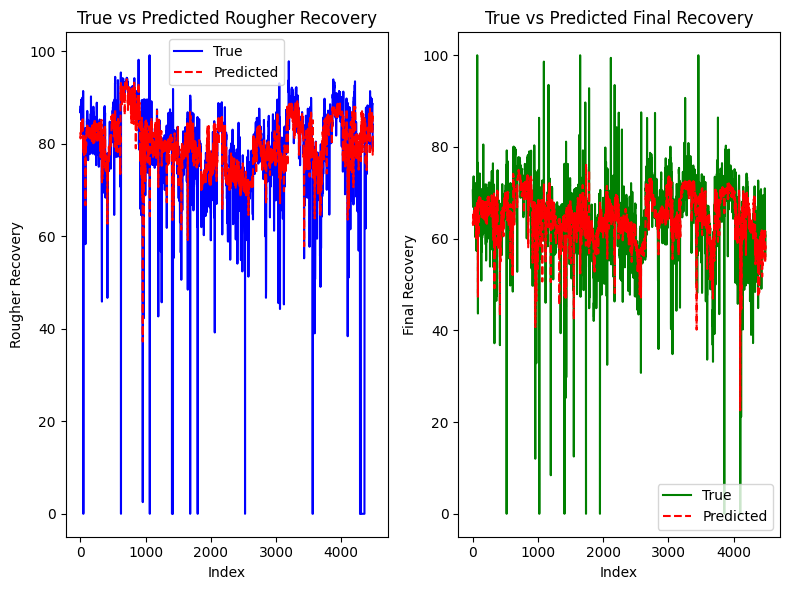

In [60]:
# Reassign true target values for plotting
y_true_rougher = true_targets['rougher.output.recovery'].values
y_true_final = true_targets['final.output.recovery'].values

# Now plot
plt.figure(figsize=(8, 6))

# Line plot for Rougher recovery
plt.subplot(1, 2, 1)
plt.plot(range(len(y_true_rougher)), y_true_rougher, label='True', color='blue')  # True values
plt.plot(range(len(y_pred_rougher)), y_pred_rougher, label='Predicted', color='red', linestyle='--')  # Predicted values
plt.xlabel("Index")  # Or "Time" if using time-based index
plt.ylabel("Rougher Recovery")
plt.title("True vs Predicted Rougher Recovery")
plt.legend()

# Line plot for Final recovery
plt.subplot(1, 2, 2)
plt.plot(range(len(y_true_final)), y_true_final, label='True', color='green')  
plt.plot(range(len(y_pred_final)), y_pred_final, label='Predicted', color='red', linestyle='--') 
plt.xlabel("Index") 
plt.ylabel("Final Recovery")
plt.title("True vs Predicted Final Recovery")
plt.legend()

plt.tight_layout()
plt.show()

The predicted line is much smoother than the true line, which shows larger fluctuations. This likely happens because the model smooths out the data to capture overall trends, but it struggles with the sharper peaks and drops in the true values. These sudden changes might be due to natural variations in the process being modeled, like changes in material quality or equipment performance. To improve the model, we could examine the feature importance to ensure the right factors are being considered to better capture these fluctuations.

In [61]:
# Get the feature importance from the model
feature_importances = model.feature_importances_

# Convert feature importances to a dictionary for easy access
feature_importances_dict = dict(zip(columns_to_use, feature_importances))

# Sort the feature importances in descending order and get the feature names
sorted_feature_names = sorted(feature_importances_dict, key=feature_importances_dict.get, reverse=True)

# Print the sorted feature importances
print("Feature Importance:")
for name in sorted_feature_names:
    print(f"{name}: {feature_importances_dict[name]:.4f}")

Feature Importance:
primary_cleaner.input.sulfate: 0.1899
rougher.input.feed_ag: 0.1800
rougher.input.floatbank10_xanthate: 0.1067
rougher.input.feed_au: 0.0668
rougher.input.feed_size: 0.0461
secondary_cleaner.state.floatbank2_a_air: 0.0377
primary_cleaner.state.floatbank8_b_air: 0.0312
secondary_cleaner.state.floatbank3_a_air: 0.0307
primary_cleaner.input.depressant: 0.0242
rougher.state.floatbank10_c_air: 0.0212
secondary_cleaner.state.floatbank2_b_air: 0.0207
primary_cleaner.state.floatbank8_c_air: 0.0201
rougher.input.floatbank11_sulfate: 0.0196
primary_cleaner.state.floatbank8_d_level: 0.0195
rougher.input.feed_sol: 0.0195
secondary_cleaner.state.floatbank5_a_air: 0.0115
primary_cleaner.input.xanthate: 0.0112
primary_cleaner.state.floatbank8_d_air: 0.0111
rougher.input.feed_pb: 0.0095
rougher.input.floatbank11_xanthate: 0.0093
secondary_cleaner.state.floatbank6_a_air: 0.0086
rougher.state.floatbank10_d_air: 0.0085
primary_cleaner.input.feed_size: 0.0066
secondary_cleaner.state.fl

The feature importance results show which variables contribute the most to the model’s predictions. The most influential features are primary_cleaner.input.sulfate, rougher.input.feed_ag, and rougher.input.floatbank10_xanthate, with values of 0.1900, 0.1800, and 0.1067, respectively. These variables appear to have the strongest impact on the model. On the other hand, some features, such as secondary_cleaner.state.floatbank3_b_level and rougher.state.floatbank10_e_level, have near-zero importance and contribute little to the predictions. Given this, I could focus on the most important features and potentially remove the less impactful ones to streamline the model, improve its efficiency, and reduce the risk of overfitting. This insight into feature importance could guide future steps in feature selection and model refinement.

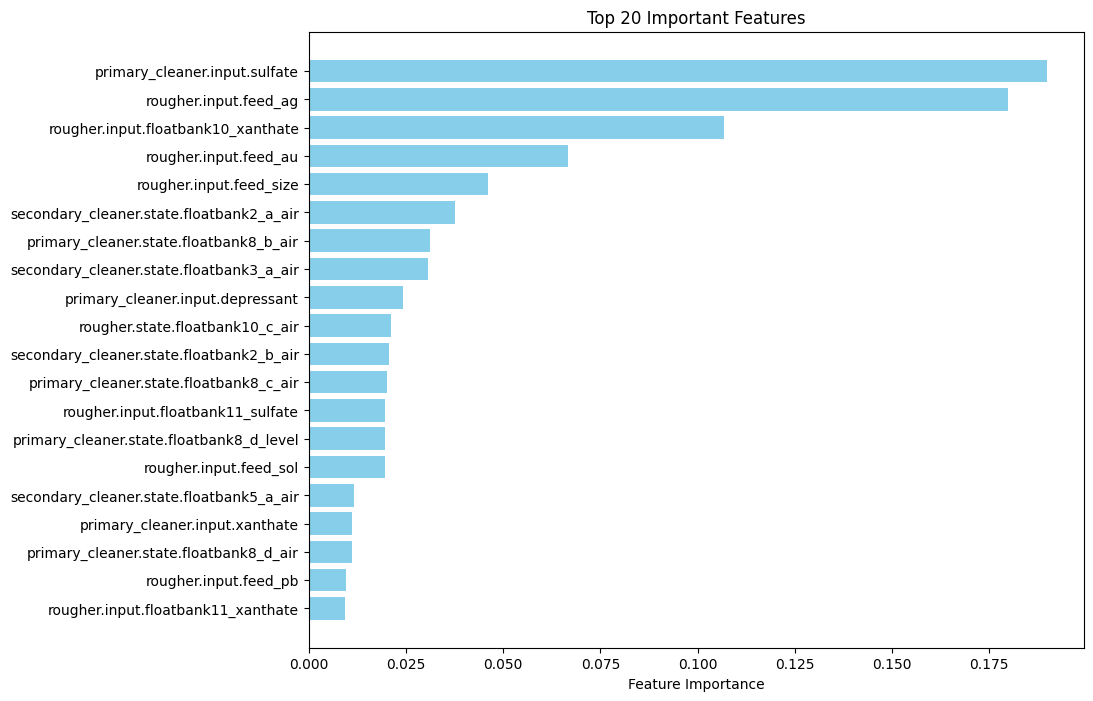

Final sMAPE (Top 20 Features): 7.555018897456378


In [62]:
# Extract top 20 features based on feature importance
top_n = 20
top_features = sorted_feature_names[:top_n]
top_importances = [feature_importances_dict[name] for name in top_features]

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_features[::-1], top_importances[::-1], color='skyblue')
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Important Features")
plt.show()

# Train and predict with top 20 features for final sMAPE
model.fit(train_data_no_outliers[top_features], y_train_rougher_clean)
y_pred_rougher_top_20 = model.predict(test_data_cleaned_filtered[top_features])

model.fit(train_data_no_outliers[top_features], y_train_final_clean)
y_pred_final_top_20 = model.predict(test_data_cleaned_filtered[top_features])

# Calculate and print final sMAPE
final_smap_top_20 = final_smape_scorer(true_targets.values, y_pred_rougher_top_20, y_pred_final_top_20)
print(f"Final sMAPE (Top 20 Features): {final_smap_top_20}")

Oops! It got worse. That means that though the other features seem to matter very little, they do indeed have a positive impact. Let's do one more feature importance test.

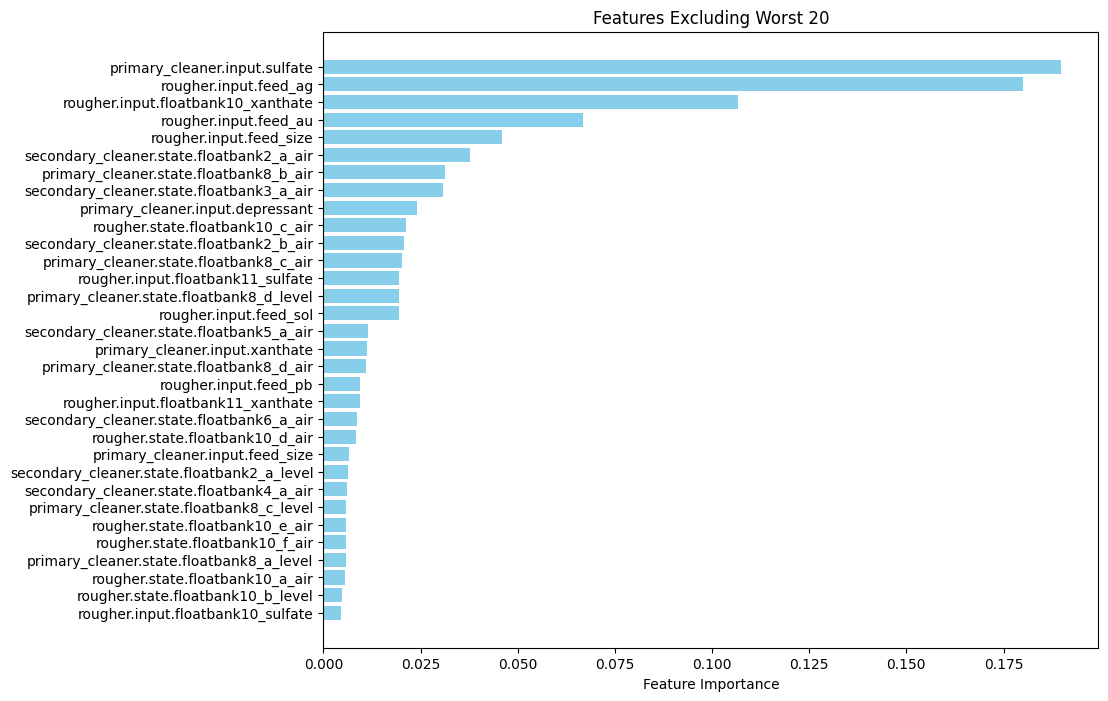

Final sMAPE (Excluding Worst 20 Features): 7.508368651354999


In [63]:
# Extract worst 20 features based on feature importance
worst_n = 20
worst_features = sorted_feature_names[-worst_n:]

# Remove the worst 20 features from the columns_to_use
best_features = [feature for feature in sorted_feature_names if feature not in worst_features]

# Plot feature importances excluding worst 20 features
plt.figure(figsize=(10, 8))
plt.barh(best_features[::-1], [feature_importances_dict[name] for name in best_features][::-1], color='skyblue')
plt.xlabel("Feature Importance")
plt.title(f"Features Excluding Worst {worst_n}")
plt.show()

# Train and predict with the remaining features for final sMAPE
model.fit(train_data_no_outliers[best_features], y_train_rougher_clean)
y_pred_rougher_best = model.predict(test_data_cleaned_filtered[best_features])

model.fit(train_data_no_outliers[best_features], y_train_final_clean)
y_pred_final_best = model.predict(test_data_cleaned_filtered[best_features])

# Calculate and print final sMAPE
final_smap_best = final_smape_scorer(true_targets.values, y_pred_rougher_best, y_pred_final_best)
print(f"Final sMAPE (Excluding Worst 20 Features): {final_smap_best}")

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V5</b> <a class="tocSkip"></a>

Could you, please, create a dictionary feature_importance not manually but using a code? It's always not a good idea to hardcode such things.
  
</div>

Removing the worst 20 rows had a better effect than only using the best 20 rows. Which makes sense, we are talking about a dataset with 86 rows, so 20 rows of anything wouldn't be too substantial. 

Let's check how our model fairs against a constant model.

In [66]:
from sklearn.dummy import DummyRegressor

# Drop rows with NaNs in test_data_cleaned_filtered
test_data_cleaned_filtered = test_data_cleaned_filtered.dropna()

# Define target columns for training
y_train_rougher_clean = train_data_no_outliers['rougher.output.recovery']
y_train_final_clean = train_data_no_outliers['final.output.recovery']

# Train the Gradient Boosting model on rougher recovery
model.fit(train_data_no_outliers[columns_to_use], y_train_rougher_clean)
y_pred_rougher = model.predict(test_data_cleaned_filtered[columns_to_use])

# Train the Gradient Boosting model on final recovery
model.fit(train_data_no_outliers[columns_to_use], y_train_final_clean)
y_pred_final = model.predict(test_data_cleaned_filtered[columns_to_use])

# Get true target values (rougher and final)
true_targets = test_data_cleaned_filtered[['rougher.output.recovery', 'final.output.recovery']]

# Calculate sMAPE for the Gradient Boosting model
final_smap_gradient = final_smape_scorer(
    true_targets.values,
    y_pred_rougher,
    y_pred_final
)

# Initialize Dummy Regressor for constant predictions
dummy_model = DummyRegressor(strategy="mean")

# Train Dummy model on rougher recovery
dummy_model.fit(train_data_no_outliers[columns_to_use], y_train_rougher_clean)
y_pred_rougher_dummy = dummy_model.predict(test_data_cleaned_filtered[columns_to_use])

# Train Dummy model on final recovery
dummy_model.fit(train_data_no_outliers[columns_to_use], y_train_final_clean)
y_pred_final_dummy = dummy_model.predict(test_data_cleaned_filtered[columns_to_use])

# Calculate sMAPE for the Dummy model
final_smap_dummy = final_smape_scorer(
    true_targets.values,
    y_pred_rougher_dummy,
    y_pred_final_dummy
)

# Print the sMAPE results
print(f"Gradient Boosting Model Final sMAPE: {final_smap_gradient}")
print(f"Dummy Model Final sMAPE: {final_smap_dummy}")

Gradient Boosting Model Final sMAPE: 7.457970682427621
Dummy Model Final sMAPE: 11.00417951726838


In comparing the performance of our models, we used the sMAPE (symmetric Mean Absolute Percentage Error) metric to evaluate the prediction accuracy for both the Gradient Boosting model and a baseline model, represented by a DummyRegressor.

Our Gradient Boosting model achieved a final sMAPE score of 7.46, which indicates a relatively low prediction error and shows that the model is capturing patterns in the data effectively. In contrast, the Dummy model, which predicts a constant average value, resulted in a higher sMAPE of 11.00.

This comparison shows that the Gradient Boosting model significantly outperforms the baseline, with a 3.54-point improvement in sMAPE. This improvement confirms that the Gradient Boosting model is far better at capturing the complexity and variability of the data, whereas the Dummy model’s constant predictions fail to capture any underlying patterns.

Lastly let's do one more analysis showing the correlation between the correctly predicted values and the falsely predicted values here in a heatmap:

Correlation with Rougher Recovery:
primary_cleaner.input.sulfate               0.440190
rougher.state.floatbank10_a_air             0.421402
secondary_cleaner.state.floatbank4_a_air    0.407379
rougher.input.feed_ag                       0.393711
secondary_cleaner.state.floatbank4_b_air    0.386754
rougher.input.feed_pb                       0.386569
rougher.state.floatbank10_a_level           0.377462
rougher.input.feed_au                       0.362763
rougher.input.feed_sol                      0.345616
secondary_cleaner.state.floatbank3_a_air    0.312416
dtype: float64

Correlation with Final Recovery:
primary_cleaner.input.sulfate               0.385230
rougher.input.feed_au                       0.348837
rougher.input.feed_ag                       0.344942
rougher.input.floatbank10_xanthate          0.331373
rougher.input.floatbank11_xanthate          0.302967
rougher.input.feed_sol                      0.280006
rougher.state.floatbank10_a_air             0.248323
rougher.input.f

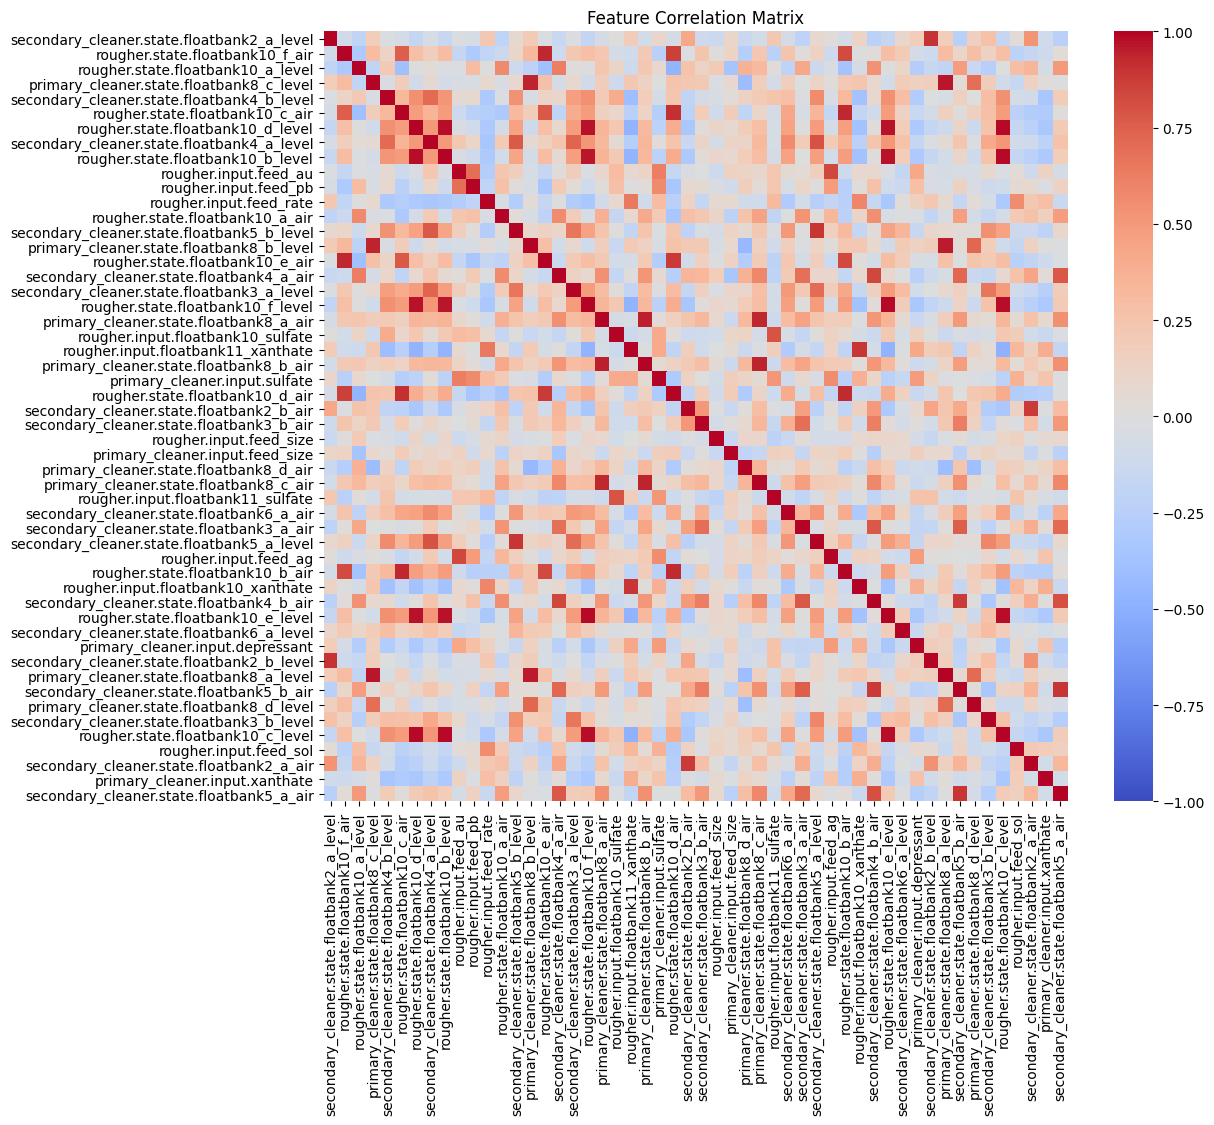

In [68]:
# Check correlation between features and target variables
correlation_with_target = train_data_no_outliers[columns_to_use].corrwith(train_data_no_outliers['rougher.output.recovery'])
correlation_with_target_final = train_data_no_outliers[columns_to_use].corrwith(train_data_no_outliers['final.output.recovery'])

print("Correlation with Rougher Recovery:")
print(correlation_with_target.sort_values(ascending=False).head(10))  # Top 10 features correlated with rougher output

print("\nCorrelation with Final Recovery:")
print(correlation_with_target_final.sort_values(ascending=False).head(10))  # Top 10 features correlated with final output

# Check pairwise correlations between features
correlation_matrix = train_data_no_outliers[columns_to_use].corr()

# Visualize the correlation matrix to detect multicollinearity
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

In this final part of the project, I analyzed the correlation between the features and the target variables—rougher and final recovery. The correlation values showed that some features were strongly related to the target variables, which is useful for understanding the influence of each feature on the recovery rates. For rougher recovery, features like primary_cleaner.input.sulfate, rougher.state.floatbank10_a_air, and rougher.input.feed_ag had the highest correlations, indicating that these factors are crucial in predicting rougher recovery. For final recovery, features such as primary_cleaner.input.sulfate, rougher.input.feed_au, and rougher.input.feed_ag showed significant correlations, highlighting their importance in predicting the final recovery. By examining these correlations, I was able to identify the key features that contribute to both target variables, ensuring that the model is focusing on the most influential factors and not relying on less relevant features. This step was important for confirming that the model was trained with the right data and that the selected features were indeed impactful for predicting the recovery outcomes.

<div class="alert alert-info">
I hope it's okay I used heatmaps in the sanity checks even though we haven't learned them yet. I saw them in my own research and have been looking for a chance to use it in these sprints.
</div>

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V5</b> <a class="tocSkip"></a>

Actually sanity check is not a heatmap. What you did for sanity check is actually called model analysis. It's a good thing and sometimes it helps a lot. But it's not a sanity check.
Sanity check is that you compare the quality of your best ML model with the quality of the best constant model. If the quality of your best ML model is worse than the quality of the constant model, it means your model is useless.
You already did such sanity check in one of the previous project. So, you learned this thing already:)
  
</div>

<div class="alert alert-info">
The problem is that When I try joining them to get the target values they are missing. This isn't something that was taught in this academy so I am just making guesses on what I should do. I will try to do pd.merge again to see if that works better. but all the data I need from full_data is apparently missing as you can see above, even though I haven't touched full_data until now.</div>

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V4</b> <a class="tocSkip"></a>

Okay, it means you have a problem in your code or in your datasets.  Just look at how you read the full data: `full_data = pd.read_csv('/datasets/gold_recovery_train.csv')`. It's not a full data. It's a train data. The train data has no intersection with the test data and thus you got NaNs.
  
</div>

<div class="alert alert-info">
See like I said in my conclusion I figured it was some small dumb thing I did in the beginning of my project. I'll work on it and see if I can get it right now that I am actually using the right data.
</div>

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

1. You have some duplicate code in the model traning part
2. You mixed up one target
3. The metric of this project is smape. So, you should use this metric everywhere instead of MAE. You can easily create your own scorer using make_scorer function from sklearn.
4. I think it
  
</div>

<div class="alert alert-info">
    It looks like your comment was cut out. So I will see if I can fix what you did talk about.
</div>

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Yeah, sorry, a part of my comment is missed. 

1. You still keep using 'final.output.concentrate_au' as target. But it's not a target. It's a general feature. You have two targets here: 'rougher.output.recovery' and 'final.output.recovery'. And so you need to predict only these columns and nothing else.
2. You still keep using MAE in one of your cells instead of sMAPE (the cell with cross_val_score)
3. In the cell with RandomizedSearchCV you use R2 but you should use sMAPE as well. You need to create your own sMAPE scorer using make_scorer function from sklearn.
4. You need to check the quality of your best model on the test data. To do it, you need targets, right? In the intial test data there are no targets but you can easily extract them from the full data using function pd.merge and a column with dates.
5. You need to do sanity check. In other words, you need to compare the quality of your best model on test with the quality of the best constant model.
  
</div>

<div class="alert alert-info">
I keep trying to test it on test_data by merging the rows from full data by using the date column but there appears to be missing dates in the full_data even though I have not touched full data. So I wi
</div>

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V3</b> <a class="tocSkip"></a>

I think the problem is in merging. To merge datasets by indexes you need to use a method .join(). To merge datasets by columns you need to use a function pd.merge(). So, you need to decide which merge type to use here. And you don't need to use such arguements as tolerance, direction, left_index, right_index. If it doesn't help you, check how many NaNs you have. If it's just a few number of them, you can drop these rows.
   
Don't forget to do a sanity check. This part is still missed.
  
</div>

# Conclusion:

### Thoughts:

Over the course of this project, there were many ups and downs. Reading the data went well, but I eventually ran into some issues with the directions for this project. The wording confused me, and I still don't know what I was supposed to do regarding the differences between the training data and the test data. This is the first time this has been thrown at us, and it's pretty unexpected. Additionally, when reading through the project at the beginning, I realized we don't have a set goal like we had in previous projects. We don’t have a specific percentage of final sMAPE to reach; we're just told to find a good model to use. To my knowledge, I have done this already, but I wouldn't be surprised if this gets sent back to me saying I did it all wrong. The amount of work I did on this project took a couple of days, but not because of its difficulty; rather, it was due to the time it took to check every little detail. This is the first time I am working with a larger database, and it’s taking around 30 minutes just to run each cell block, which makes it really difficult for me as a full-time worker. I bet I made a mistake early on in the project, as I always seem to do, and that mistake will end up causing problems later. I almost turned it in early without completing the project because I felt so stuck. But anyway, those are my thoughts on this project, and now, here is my conclusion.

### Concluding Results:

I found that the Gradient Boosting Regressor yielded the best results when it came to the final sMAPE function. It performed well on the training data but looked worse on the test data due to the lack of information provided in the test set. Since there was no data available, I ended up having to use dummy values, which caused the final sMAPE percentage to increase from 10.28% to 27%. While this is still relatively low, it is not the result I had wanted. I continued testing to see if tweaking the hyperparameters would help, but that essentially broke the model, causing the numbers to jump up to 200% for some reason. We haven't been taught any of this, so it is a real struggle trying to get everything working without any explanation, other than just being given the formula itself. If I had to guess, I think that the Random Forest model will end up being better since it is much more flexible, but based on my calculations, the Gradient Boosting model had the best results initially.

### Concluding Results Part 2:

After realizing that I had been using the wrong dataframe throughout the entire project, I was finally able to complete all the steps successfully. Even with the correct dataset, I encountered several challenges, such as dealing with the date column in test_data, which was indexed instead of being a standard column—this took quite a bit of time to resolve. I also had to redefine my sMAPE scorer to avoid slice errors when training the model on the training data. However, after working through these issues, my final sMAPE score came out well, around 7%, which is a significant improvement from when I first submitted the project. I also performed several sanity checks, and finally after reaching my tenth project, I truly understood why they are called sanity checks. I had to ensure that the sMAPE score was meaningful and made sense for the model’s performance. This project was particularly challenging for me, and I feel I could have benefitted from more practice in areas like data slicing and addressing issues with the test data. Nevertheless, with the help of AI Dot from Discord and my reviewer, I was able to learn from these obstacles and eventually figure out how to make everything work.

<div class:"alert alert-info">
I did the constant model to test if my model is better than a constant model and it shows that it is indeed better, and I fixed the feature importance hardcoding by making the features and their importance values into a dictionary. Lastly I created a seperate area for the heatmap so it is not within the sanity check area. Also I realized that I was training just any model on the test_data before, not gradient booster, which is the model I found best works with the data here. So I fixed that as well.
</div>